# Tarea 1 FIS2436

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_sources,detect_threshold,deblend_sources,SourceCatalog
from photutils.isophote import EllipseGeometry,Ellipse
from photutils.aperture import EllipticalAperture

Link utilizado: https://www.legacysurvey.org/viewer/fits-cutout?ra=132.8503&dec=25.1559&layer=ls-dr10&pixscale=0.262&bands=grz&size=1024

Referencia: https://www.legacysurvey.org/dr10/description/

Coordenadas: RA=132.8503 y DEC=25.155

In [2]:
#Abrimos el fits y vemos que hay
imagen=fits.open('imagen10.fits')
imagen.info()

Filename: imagen10.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      28   (1024, 1024, 3)   float32   


In [3]:
#Extraemos los datos del fits
layers=imagen[0].data

In [4]:
#Separamos los filtros, del más azul al más rojo (la info de cuál es cuál está en el header)
g_layer=layers[0]
r_layer=layers[1]
z_layer=layers[2]

In [5]:
#Estimamos el ruido de background para ver si es necesario sacarlo
bkg_estimator = MedianBackground()
bkg = Background2D(g_layer, 64, filter_size=5, bkg_estimator=bkg_estimator)
bdata = g_layer-bkg.background
g_layer-bdata

array([[6.43123516e-05, 6.43115992e-05, 6.43100945e-05, ...,
        4.32443921e-05, 4.32443921e-05, 4.32443921e-05],
       [6.43263276e-05, 6.43255716e-05, 6.43240596e-05, ...,
        4.32443921e-05, 4.32443921e-05, 4.32443921e-05],
       [6.43542797e-05, 6.43535164e-05, 6.43519897e-05, ...,
        4.32443921e-05, 4.32443921e-05, 4.32443921e-05],
       ...,
       [1.96845789e-04, 1.96839599e-04, 1.96827218e-04, ...,
        5.48874660e-05, 5.48869569e-05, 5.48867024e-05],
       [1.96931150e-04, 1.96924935e-04, 1.96912504e-04, ...,
        5.48849888e-05, 5.48844812e-05, 5.48842274e-05],
       [1.96973831e-04, 1.96967603e-04, 1.96955146e-04, ...,
        5.48837502e-05, 5.48832434e-05, 5.48829900e-05]])

Como vemos el ruido de background es bajísimo (tiene sentido ya que los datos ya están reducidos), no es necesario corregirlo, así que ya podemos proceder a identificar fuentes, hechemos un vistazo a la imagen

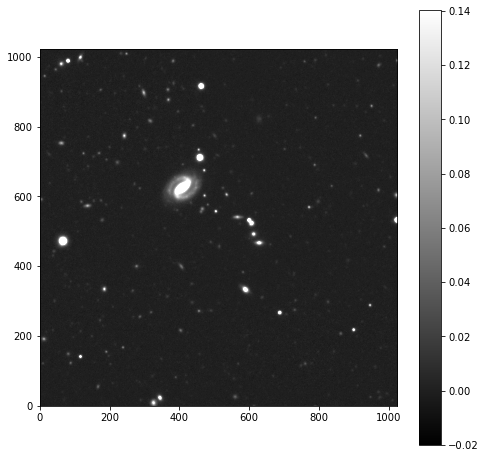

In [6]:
plt.figure(figsize=(8,8))
plt.imshow(r_layer,cmap='gray', origin='lower',\
           vmin=-0.02, vmax=np.mean(r_layer)+np.std(r_layer))
plt.colorbar()
plt.show()

## Catálogo

In [7]:
#Definimos nuestra función para generar mapas de fuentes, uno simple y otro final con deblend aplicado
def segm_map_gen(d,ns,np,c,np2): #(data,nsigma,npixels,contrast,npixels2)
    mapa_simple=detect_sources(d, detect_threshold(d,nsigma=ns), npixels=np)
    mapa_final=deblend_sources(d,mapa_simple,contrast=c,npixels=np2,progress_bar=False)
    return mapa_simple,mapa_final

In [8]:
#Generamos ambos mapas y vemos la cantidad de fuentes detectadas en cada unos (simple,deblended)
g_map,sg_map=segm_map_gen(g_layer,3,5,0.1,5)
g_map.nlabels,sg_map.nlabels

(226, 232)

In [9]:
r_map,sr_map=segm_map_gen(r_layer,3,5,0.1,5)
r_map.nlabels,sr_map.nlabels

(243, 254)

In [10]:
z_map,sz_map=segm_map_gen(z_layer,3,5,0.1,5)
z_map.nlabels,sz_map.nlabels

(254, 261)

Veamos como se ven estos mapas

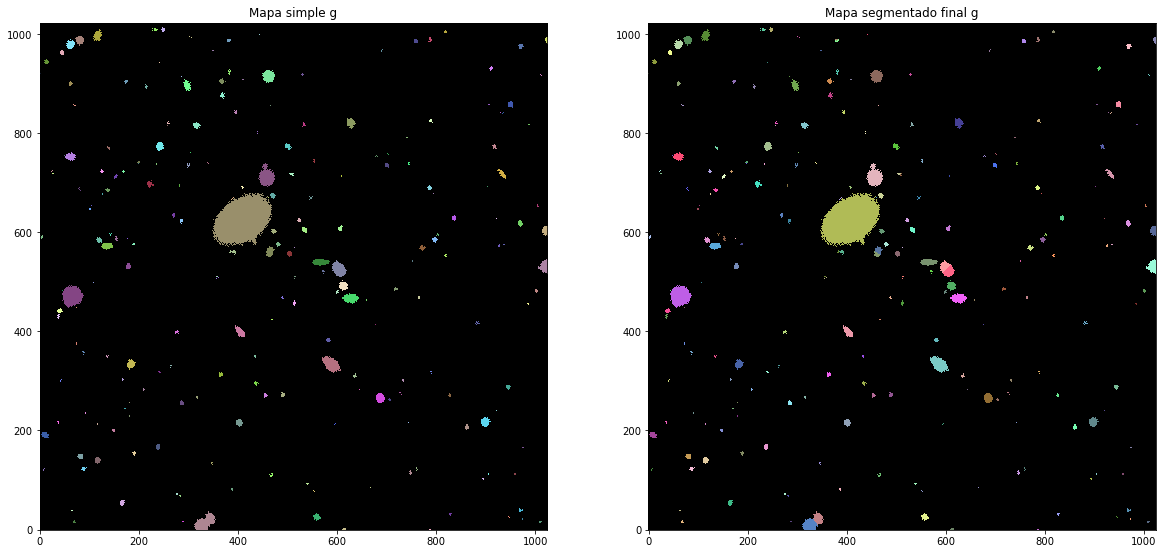

In [11]:
cmapa = g_map.make_cmap(seed=1) #generamos un mapa de colores para diferenciar las fuentes
cmapa2 = sg_map.make_cmap(seed=2)

fig,axs=plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(g_map,cmap=cmapa, origin="lower", interpolation='nearest')
axs[0].set_title('Mapa simple g')

axs[1].imshow(sg_map,cmap=cmapa2, origin="lower", interpolation='nearest')
axs[1].set_title('Mapa segmentado final g')
plt.show()

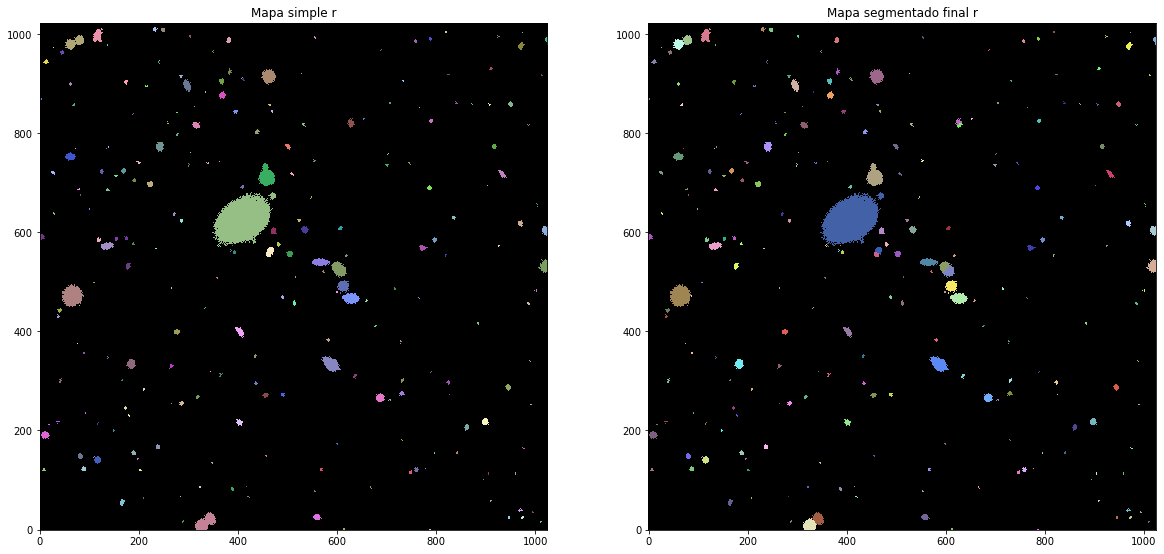

In [12]:
cmapa = r_map.make_cmap(seed=1) #generamos un mapa de colores para diferenciar las fuentes
cmapa2 = sr_map.make_cmap(seed=2)

fig,axs=plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(r_map,cmap=cmapa, origin="lower", interpolation='nearest')
axs[0].set_title('Mapa simple r')

axs[1].imshow(sr_map,cmap=cmapa2, origin="lower", interpolation='nearest')
axs[1].set_title('Mapa segmentado final r')
plt.show()

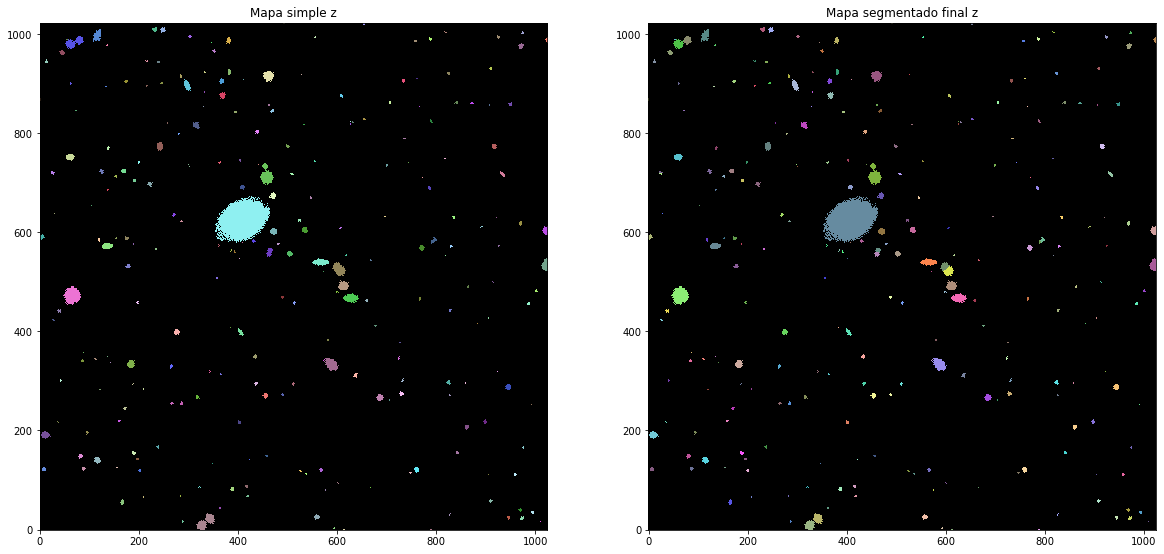

In [13]:
cmapa = z_map.make_cmap(seed=1) #generamos un mapa de colores para diferenciar las fuentes
cmapa2 = sz_map.make_cmap(seed=2)

fig,axs=plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(z_map,cmap=cmapa, origin="lower", interpolation='nearest')
axs[0].set_title('Mapa simple z')

axs[1].imshow(sz_map,cmap=cmapa2, origin="lower", interpolation='nearest')
axs[1].set_title('Mapa segmentado final z')
plt.show()

In [14]:
#Generamos nuestro catálogo simple y lo pasamos a tabla
g_cat=SourceCatalog(g_layer,sg_map)
g_tbl=g_cat.to_table()
g_tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,612.2229543385915,1.2379872166681143,None,608,618,0,4,34.0,2.522338871047338,1.19244639203334,-1.6776139872421123,0.88119432025553,0.005145953502506018,0.01179902721196413,0.0,0.2672213688492775,nan,0.4486002420473796,nan
2,786.5965822046901,0.39269964103301197,None,784,789,0,2,10.0,1.538552470741137,0.6334964986669168,2.554324915249189,0.9112975724329697,0.0055026100017130375,0.011191409081220627,0.0,0.07928683841601014,nan,0.14547572728988445,nan
3,68.8541813342273,16.39371401810169,None,66,72,14,19,21.0,1.661289280473046,1.27598191577941,33.118099126099196,0.6403691707248237,0.0050802393816411495,0.009151997044682503,0.0,0.13463669642806053,nan,0.40845647074859454,nan
4,1008.1075425134376,16.414405372787932,None,1005,1011,14,19,18.0,1.5822031478286709,1.2161417752190289,3.3376718017241735,0.6396837669811748,0.005074608139693737,0.008810620754957199,0.0,0.11260597174987197,nan,0.27381272569769116,nan
5,288.07763342088623,16.939944853332793,None,287,289,16,18,7.0,0.9250201136713792,0.5275888115013494,-43.64005926459108,0.8213990813486113,0.005661276169121265,0.008817128837108612,0.0,0.050338874105364084,nan,0.2252061236570823,nan
6,557.6872196527584,25.9037553095114,None,550,566,19,33,146.0,3.30568422208336,2.9635696003870944,-17.546969774190988,0.44302922888456053,0.005127016920596361,0.02003030851483345,0.0,1.4427849696949124,nan,2.1120662592244717,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,390.9340644512816,559.8452973743401,None,385,395,555,563,54.0,2.7231874915855308,1.725904891215303,-23.568667255059616,0.7735124162107434,0.005057769361883402,0.012045796029269695,0.0,0.3807021421380341,nan,2.204551295967473,nan


In [15]:
r_cat=SourceCatalog(r_layer,sr_map)
r_tbl=r_cat.to_table()
r_tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,611.6912322953592,1.114824020546893,None,608,615,0,3,22.0,1.7826669023365669,1.0000801943851654,11.208901382674245,0.8278142565130823,0.010837545618414879,0.024550415575504303,0.0,0.3553949473425746,nan,0.7018035578548707,nan
2,786.9880927552192,0.3214459912637999,None,783,791,0,2,14.0,2.1685271450781065,0.5700338330065461,-1.9761430868186702,0.9648321280700375,0.012081936933100224,0.032275035977363586,0.0,0.2736654719337821,nan,0.4914912297009477,nan
3,287.64708897089645,16.796922015504435,None,286,289,14,19,16.0,1.3653183149651722,0.9229364863233468,86.44928802907863,0.7369141822796399,0.011496949009597301,0.024025065824389458,0.0,0.25545417331159115,nan,0.7317245598416727,nan
4,1008.3514614266018,16.37572776475507,None,1007,1010,14,19,15.0,1.324005066949955,0.8836656102564552,65.75448908206491,0.7446827581441742,0.010840985924005508,0.018104614689946175,0.0,0.20660289376974106,nan,0.5233538287377199,nan
5,557.9752966361264,26.05051579673573,None,551,567,20,32,147.0,3.2802506925294774,2.8744290124464995,-22.46162623900872,0.48179613838155966,0.010878665372729301,0.048915013670921326,0.0,3.3686965936794877,nan,4.829495897523982,nan
6,971.5247517815736,24.35300076711226,None,969,976,20,27,34.0,2.2270393169888147,1.3422524855285694,36.05418443740887,0.7979624739446942,0.010819371789693832,0.023386143147945404,0.0,0.4950317405164242,nan,1.4466378893383158,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,358.18358521441166,572.7227132894162,None,357,359,570,575,11.0,1.597958131453138,0.7015097291451865,-87.00529017759419,0.8984851936163436,0.01123633049428463,0.016964076086878777,0.0,0.1516921939328313,nan,1.4672790694873044,nan


In [16]:
z_cat=SourceCatalog(z_layer,sz_map)
z_tbl=z_cat.to_table()
z_tbl

label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int64,float64,float64,object,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,611.4252034257241,0.7942205625008326,None,609,613,0,2,8.0,1.331981929930777,0.5058438177756805,-26.227719060608052,0.9250818530510824,0.029050201177597046,0.05471351742744446,0.0,0.3007651884108782,nan,0.9693597744573277,nan
2,787.5677381831637,0.2692162295879053,None,786,789,0,1,7.0,0.9900880877318929,0.4252074863935488,8.116778197022047,0.9030838366490226,0.030011605471372604,0.10414308309555054,0.0,0.4192483425140381,nan,0.716341731279978,nan
3,592.7955573970797,3.3366911146835596,None,591,594,2,5,11.0,1.064801970327703,0.8755743280642827,67.93673808078445,0.5690709595515318,0.029348773881793022,0.04625730961561203,0.0,0.39408641681075096,nan,1.050671598463324,nan
4,287.7178685026461,16.634156523085384,None,287,289,15,19,9.0,1.0615579152993189,0.7353798118890001,-89.45946075014015,0.7211908733957938,0.029154259711503983,0.06240919977426529,0.0,0.3821075987070799,nan,1.3086250875883159,nan
5,1008.2339699119804,16.550846743391386,None,1007,1009,16,17,5.0,0.7174377733654969,0.46475488696710066,-18.923480697026807,0.7618119927899384,0.029397515580058098,0.04880860447883606,0.0,0.1933592539280653,nan,0.853448507368998,nan
6,971.1848045761651,24.02706181767519,None,966,976,20,30,48.0,2.4665120862812335,1.6083876451521,53.99831191924305,0.7581416416843235,0.028887812048196793,0.09192422032356262,0.0,2.209723372012377,nan,4.334987682733483,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,26.091041335382748,717.597858817618,None,23,29,715,719,16.0,1.585873853544062,0.9780668784124299,-10.26250079259969,0.7871693793660278,0.02883054129779339,0.06094270572066307,0.0,0.6379187610000372,nan,2.304464390518012,nan


In [17]:
#Generamos nuestra imagen a color
rgb=make_lupton_rgb(z_layer,r_layer,g_layer, minimum=0, stretch=0.1, Q=8)

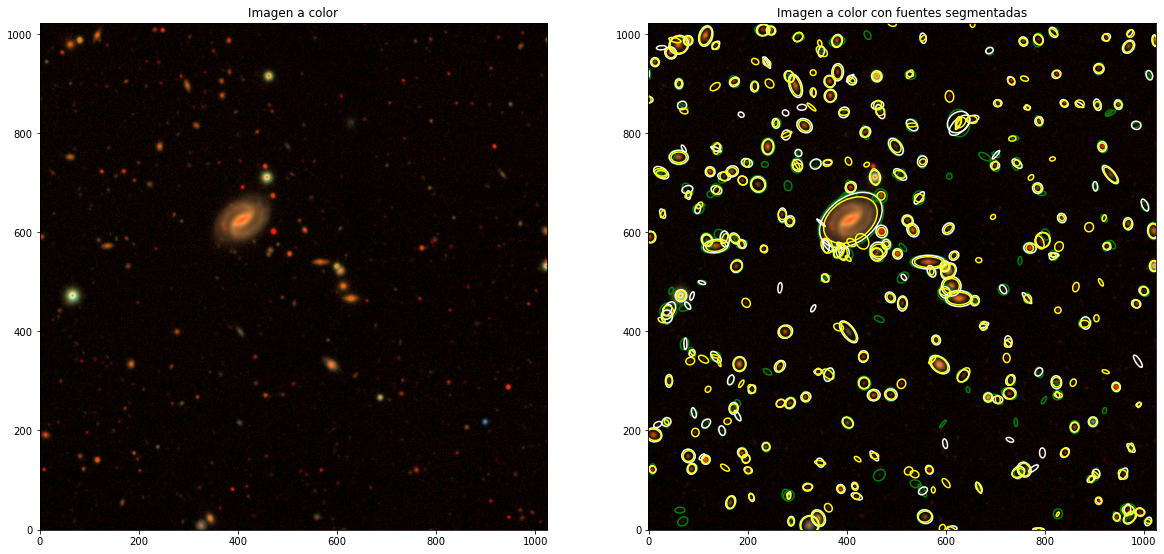

In [18]:
#Graficamos nuestra imagen a color y las fuentes detectadas en cada catálogo
fig,axs=plt.subplots(1,2,figsize=(20,20))
axs[0].imshow(rgb, origin='lower',\
           vmin=0, vmax=np.mean(rgb)+np.std(rgb))
axs[0].set_title('Imagen a color')

axs[1].imshow(rgb, origin='lower',\
           vmin=0, vmax=np.mean(rgb)+np.std(rgb))
axs[1].set_title('Imagen a color con fuentes segmentadas')
g_cat.plot_kron_apertures(color='green', lw=1.5)
r_cat.plot_kron_apertures(color='white', lw=1.5)
z_cat.plot_kron_apertures(color='yellow', lw=1.5)
plt.show()

## Isofotas

In [19]:
obj1=g_layer[525:725,300:500]

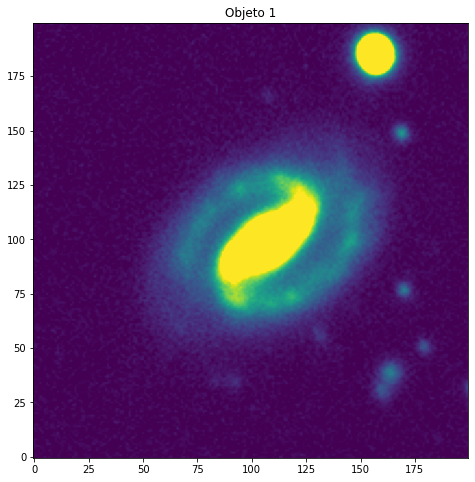

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(obj1, origin='lower',\
           vmin=0, vmax=np.mean(g_layer)+np.std(g_layer))
plt.title('Objeto 1')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d8f14f40>,)

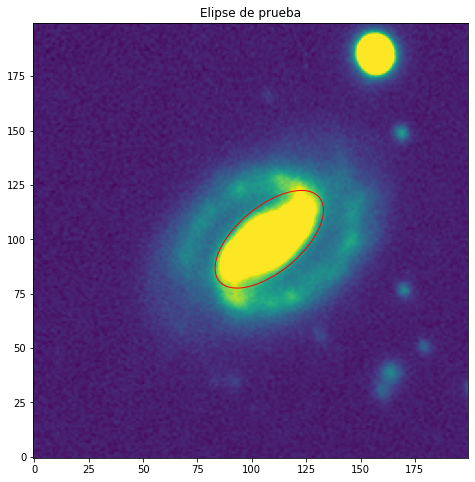

In [21]:
#Generamos nuestra elipse de prueba con los siguientes elementos :
#   (x0,y0) son las coordenadas centrales de la elipse
#   sma es la medida del semieje mayor (en pixeles)
#   eps es la elipticidad
#   pa es el ángulo (en radianes) respecto al eje x

geometry = EllipseGeometry(x0=108, y0=100, sma=30, eps=0.5,pa=40.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj1, origin='lower',vmax=np.mean(g_layer)+np.std(g_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

In [22]:
def isofogen(obj,geo_obj): #Función para generar una lista de isofotas 
    return Ellipse(obj,geo_obj).fit_image()

In [23]:
def aper(f,x): #Función para graficar isofotas
    return EllipticalAperture((f.x0[x], f.y0[x]), f.sma[x],\
                          f.sma[x] * (1 - f.eps[x]),f.pa[x])

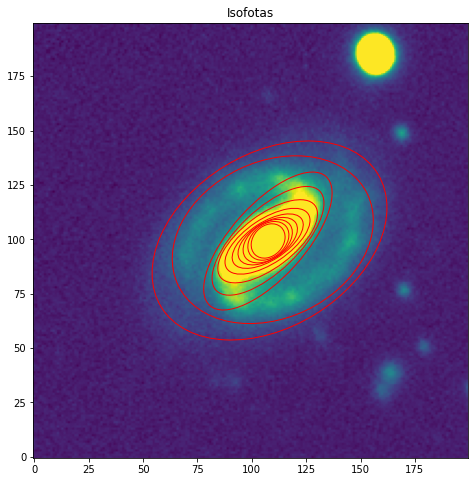

In [24]:
iso1=isofogen(obj1,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj1, origin='lower',vmax=np.mean(g_layer)+np.std(g_layer))
plt.title('Isofotas')
for i in range (30,52,2):
    aper(iso1,i).plot(color='red')

Hagamos lo mismo para 8 objetos más

### Objeto 2

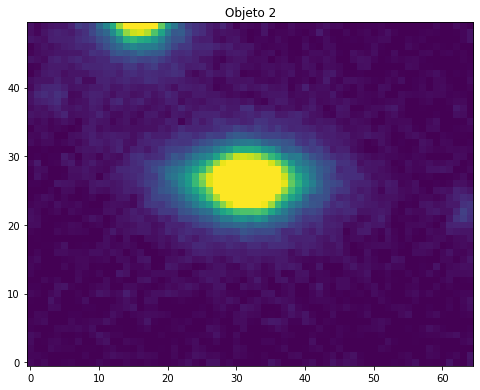

In [25]:
#Definimos el objeto
obj2=r_layer[440:490,595:660]

plt.figure(figsize=(8,8))
plt.imshow(obj2, origin='lower',\
           vmin=0, vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Objeto 2')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d8bcbf40>,)

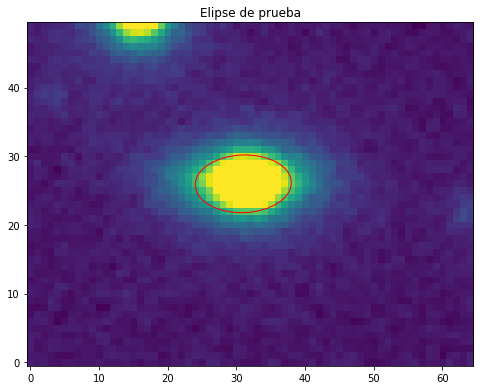

In [26]:
#Elipse de prueba
geometry = EllipseGeometry(x0=31, y0=26, sma=7, eps=0.4,pa=2.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj2, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

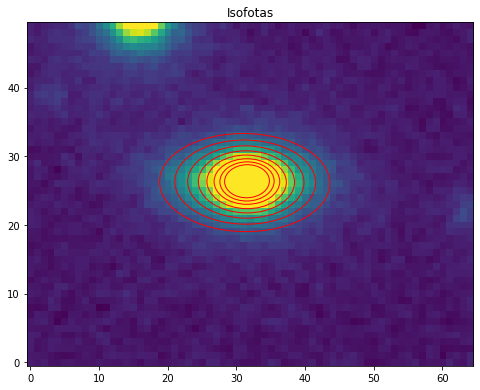

In [27]:
#Generamos y graficamos las isofotas
iso2=isofogen(obj2,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj2, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Isofotas')
for i in range (20,36,2):
    aper(iso2,i).plot(color='red')

### Objeto 3

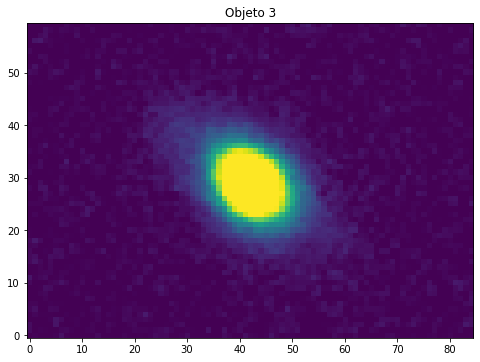

In [28]:
#Definimos el objeto
obj3=r_layer[304:364,545:630]

plt.figure(figsize=(8,8))
plt.imshow(obj3, origin='lower',\
           vmin=0, vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Objeto 3')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d8a2b040>,)

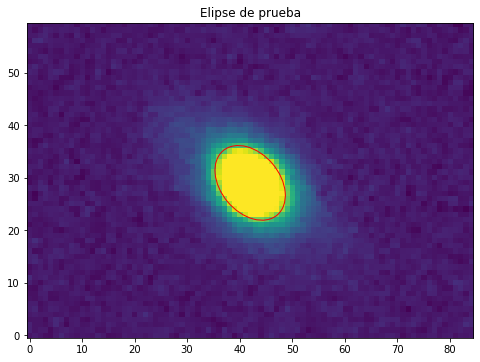

In [29]:
#Elipse de prueba
geometry = EllipseGeometry(x0=42, y0=29, sma=8, eps=0.3,pa=-50.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj3, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

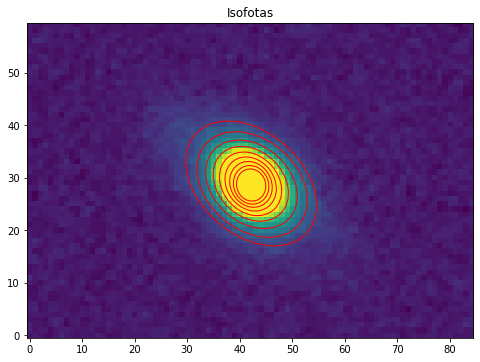

In [30]:
#Generamos y graficamos las isofotas
iso3=isofogen(obj3,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj3, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Isofotas')
for i in range (20,38,2):
    aper(iso3,i).plot(color='red')

### Objeto 4

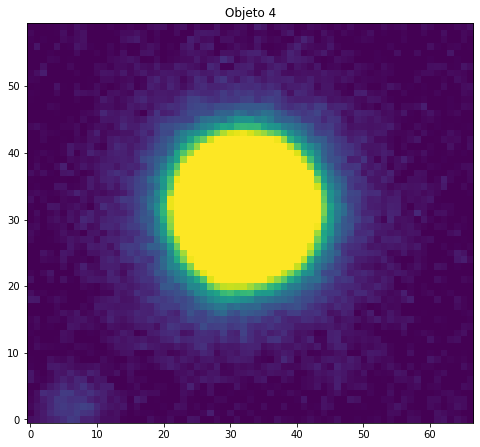

In [31]:
#Definimos el objeto
obj4=r_layer[440:500,33:100]

plt.figure(figsize=(8,8))
plt.imshow(obj4, origin='lower',\
           vmin=0, vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Objeto 4')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d89199a0>,)

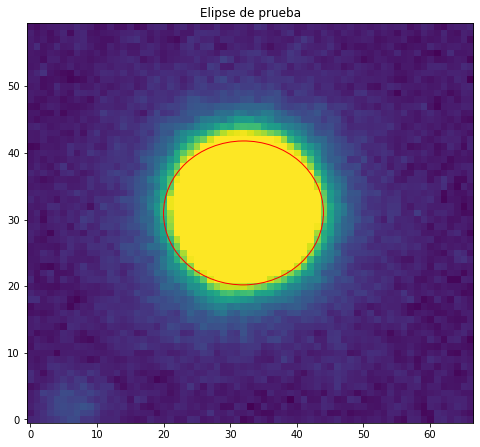

In [32]:
#Elipse de prueba
geometry = EllipseGeometry(x0=32, y0=31, sma=12, eps=0.1,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj4, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

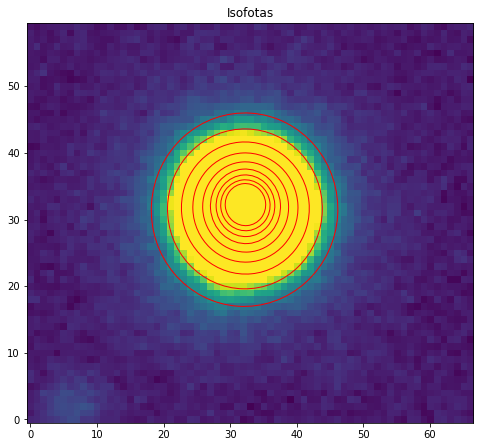

In [33]:
#Generamos y graficamos las isofotas
iso4=isofogen(obj4,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj4, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Isofotas')
for i in range (20,38,2):
    aper(iso4,i).plot(color='red')

### Objeto 5

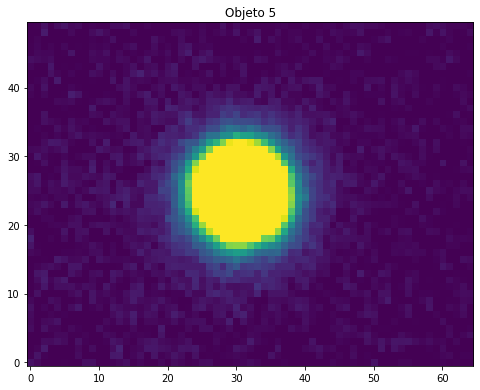

In [34]:
#Definimos el objeto
obj5=r_layer[890:940,430:495]

plt.figure(figsize=(8,8))
plt.imshow(obj5, origin='lower',\
           vmin=0, vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Objeto 5')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d877d970>,)

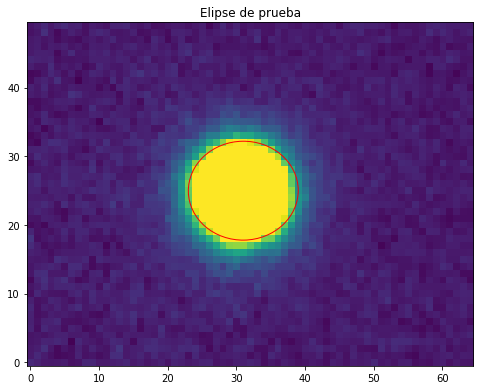

In [35]:
#Elipse de prueba
geometry = EllipseGeometry(x0=31, y0=25, sma=8, eps=0.1,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj5, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

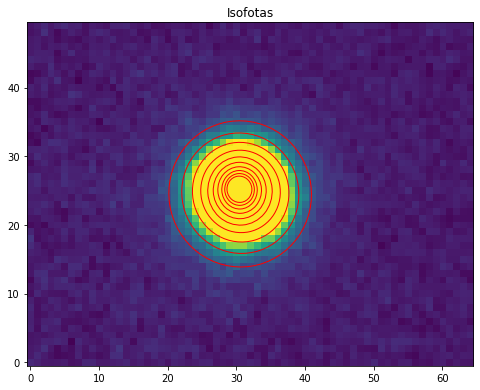

In [36]:
#Generamos y graficamos las isofotas
iso5=isofogen(obj5,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj5, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Isofotas')
for i in range (15,34,2):
    aper(iso5,i).plot(color='red')

### Objeto 6

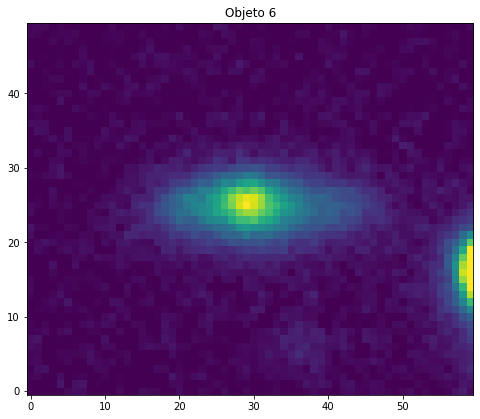

In [37]:
#Definimos el objeto
obj6=r_layer[515:565,535:595]

plt.figure(figsize=(8,8))
plt.imshow(obj6, origin='lower',\
           vmin=0, vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Objeto 6')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d8656670>,)

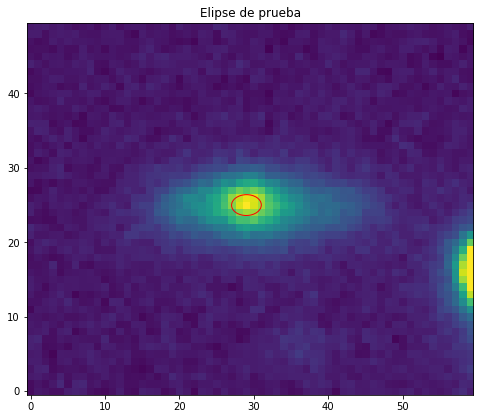

In [38]:
#Elipse de prueba
geometry = EllipseGeometry(x0=29, y0=25, sma=2, eps=0.3,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj6, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

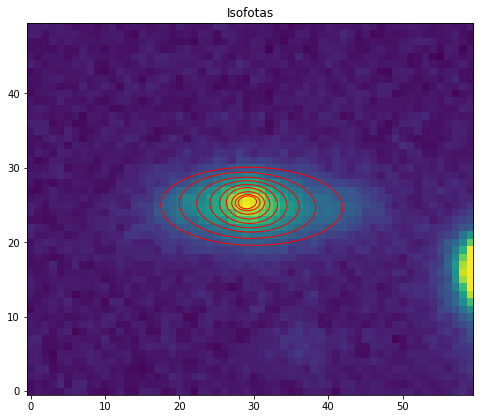

In [39]:
#Generamos y graficamos las isofotas
iso6=isofogen(obj6,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj6, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Isofotas')
for i in range (10,36,3):
    aper(iso6,i).plot(color='red')

### Objeto 7

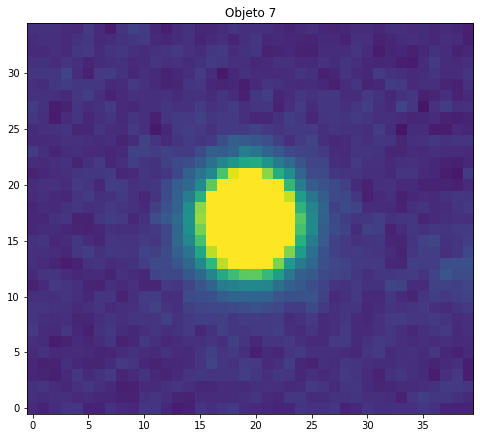

In [40]:
#Definimos el objeto
obj7=r_layer[250:285,666:706]

plt.figure(figsize=(8,8))
plt.imshow(obj7, origin='lower',\
           vmin=-0.02, vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Objeto 7')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d86c3c70>,)

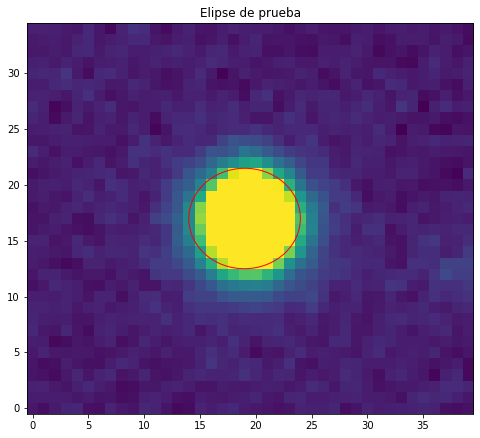

In [41]:
#Elipse de prueba
geometry = EllipseGeometry(x0=19, y0=17, sma=5, eps=0.1,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj7, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

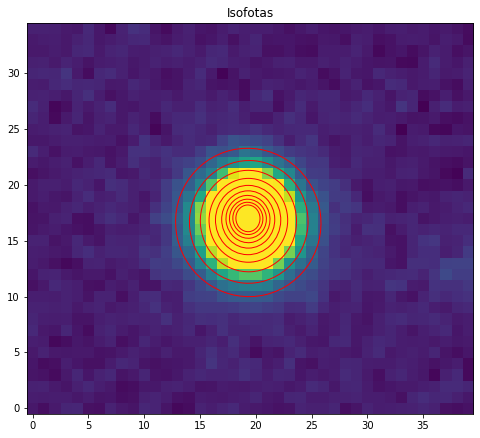

In [42]:
#Generamos y graficamos las isofotas
iso7=isofogen(obj7,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj7, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Isofotas')
for i in range (10,30,2):
    aper(iso7,i).plot(color='red')

### Objeto 8

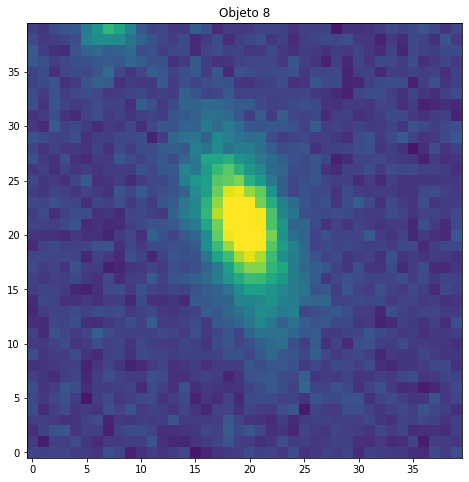

In [43]:
#Definimos el objeto
obj8=z_layer[875:915,277:317]

plt.figure(figsize=(8,8))
plt.imshow(obj8, origin='lower',\
           vmin=-0.05, vmax=np.mean(z_layer)+np.std(z_layer))
plt.title('Objeto 8')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d899c280>,)

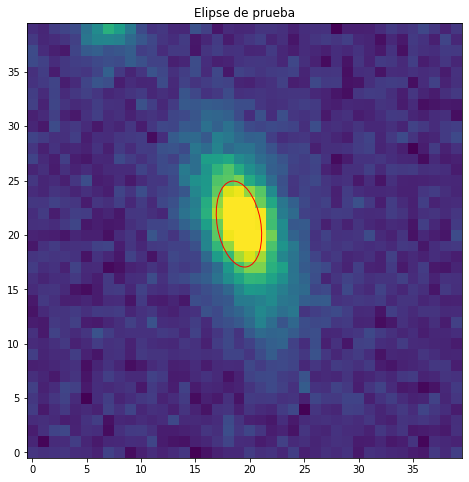

In [44]:
#Elipse de prueba
geometry = EllipseGeometry(x0=19, y0=21, sma=4, eps=0.5,pa=-80.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj8, origin='lower',vmax=np.mean(z_layer)+np.std(z_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

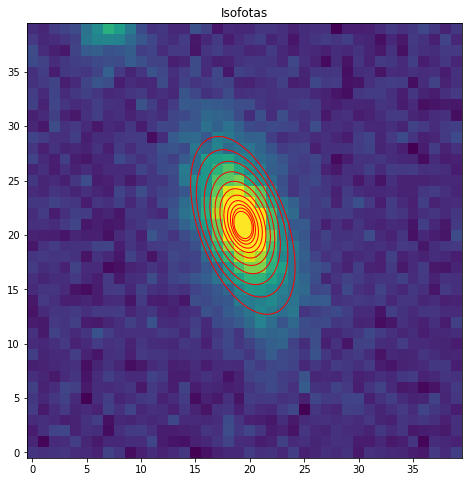

In [45]:
#Generamos y graficamos las isofotas
iso8=isofogen(obj8,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj8, origin='lower',vmax=np.mean(z_layer)+np.std(z_layer))
plt.title('Isofotas')
for i in range (10,32,2):
    aper(iso8,i).plot(color='red')

### Objeto 9

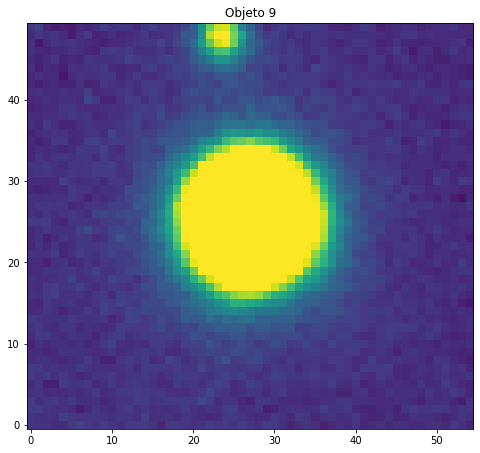

In [46]:
#Definimos el objeto
obj9=r_layer[685:735,430:485]

plt.figure(figsize=(8,8))
plt.imshow(obj9, origin='lower',\
           vmin=-0.02, vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Objeto 9')
plt.show()

(<matplotlib.patches.Ellipse at 0x7fc4d8c2d940>,)

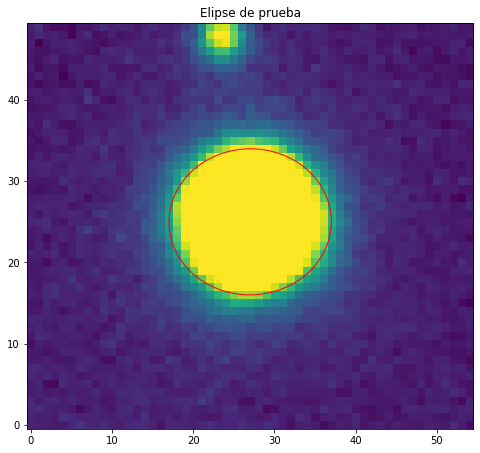

In [47]:
#Elipse de prueba
geometry = EllipseGeometry(x0=27, y0=25, sma=10, eps=0.1,pa=1.0 * np.pi / 180.0)
apert = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,\
                           geometry.sma * (1 - geometry.eps),geometry.pa)

plt.figure(figsize=(8,8))
plt.imshow(obj9, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Elipse de prueba')
apert.plot(color='red')

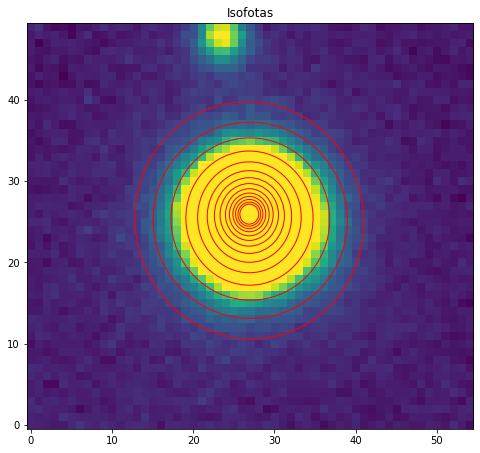

In [48]:
#Generamos y graficamos las isofotas
iso9=isofogen(obj9,geometry)

plt.figure(figsize=(8,8))
plt.imshow(obj9, origin='lower',vmax=np.mean(r_layer)+np.std(r_layer))
plt.title('Isofotas')
for i in range (10,38,2):
    aper(iso9,i).plot(color='red')